In [2]:
import Pkg
Pkg.add("ITensors")
Pkg.add("NPZ")
Pkg.add("GLM")
Pkg.add("Plots")

    Updating registry at `C:\Users\Administrator\.julia\registries\General.toml`
   Resolving package versions...
   Installed KrylovKit ──────── v0.8.1
   Installed StridedViews ───── v0.3.1
   Installed ConstructionBase ─ v1.5.8
   Installed NDTensors ──────── v0.3.42
   Installed ITensors ───────── v0.6.17
    Updating `C:\Users\Administrator\.julia\environments\v1.10\Project.toml`
  [9136182c] + ITensors v0.6.17
    Updating `C:\Users\Administrator\.julia\environments\v1.10\Manifest.toml`
  [7d9f7c33] + Accessors v0.1.37
  [dce04be8] + ArgCheck v2.3.0
  [4c555306] + ArrayLayouts v1.10.3
⌅ [198e06fe] + BangBang v0.3.40
  [9718e550] + Baselet v0.1.1
  [c3b6d118] + BitIntegers v0.3.1
  [8e7c35d0] + BlockArrays v1.1.0
  [a33af91c] + CompositionsBase v0.1.2
  [187b0558] + ConstructionBase v1.5.8
  [244e2a9f] + DefineSingletons v0.1.2
  [85a47980] + Dictionaries v0.4.2
  [da5c29d0] + EllipsisNotation v1.8.0
  [e189563c] + ExternalDocstrings v0.1.1
  [41a02a25] + Folds v0.2.10
  [d9f16b24

In [1]:
using ITensors
using Pkg
using NPZ

In [2]:

N = 64

# Make an array of N Index objects with alternating
# "S=1/2" and "S=1" tags on odd versus even sites
# (The first argument n->isodd(n) ... is an 
# on-the-fly function mapping integers to strings)

sites = siteinds("S=1/2", N)
entangle_E = []
pa = []
P0_list = []
P1_list = []

angle_list = [0.0, 0.025*pi, 0.05*pi, 0.1*pi, 0.15*pi, 0.2*pi, 0.25*pi, 0.3*pi, 0.35*pi, 0.4*pi, 0.45*pi, 0.5*pi]
ITensors.op(::OpName"P0",::SiteType"S=1/2") =
 [1 0
  0 0]
ITensors.op(::OpName"P1",::SiteType"S=1/2") =
 [0 0
  0 1]

for angle in angle_list
    all_tensors = []
    os = OpSum()
    os -= 4.0*cos(angle)^2, "Sz",1,"Sx",2
    os -= 4.0*cos(angle)*sin(angle), "Sz",1,"Sz",2
    os += 4.0*sin(angle)^2, "Sx",1,"Sz",2
    os += 4.0*cos(angle)*sin(angle), "Sx",1,"Sx",2
    
    os -= 8.0*cos(angle)^3, "Sx", N-2,"Sz",N-1,"Sz",N
    os -= 8.0*cos(angle)^2*sin(angle), "Sz",N-2,"Sz",N-1, "Sz",N
    os += 8.0*cos(angle)^2*sin(angle), "Sx",N-2,"Sx",N-1, "Sz",N
    os += 8.0*cos(angle)^2*sin(angle), "Sx",N-2,"Sz",N-1, "Sx",N
    os += 8.0*cos(angle)*sin(angle)^2, "Sz",N-2,"Sx",N-1, "Sz",N
    os += 8.0*cos(angle)*sin(angle)^2, "Sz",N-2,"Sz",N-1, "Sx",N
    os -= 8.0*cos(angle)*sin(angle)^2, "Sx",N-2,"Sx",N-1, "Sx",N
    os -= 8.0*sin(angle)^3, "Sz",N-2,"Sx",N-1, "Sx",N
    
    os -= 4.0*cos(angle)^2, "Sx", N-1,"Sx",N
    os -= 4.0*cos(angle)*sin(angle), "Sx", N-1,"Sz",N
    os -= 4.0*sin(angle)^2, "Sz", N-1,"Sz",N
    os -= 4.0*cos(angle)*sin(angle), "Sz", N-1,"Sx",N
    
    for j=1:N-3
        os -= 8.0*cos(angle)^3, "Sx",j,"Sz",j+1,"Sx",j+2
        os -= 8.0*cos(angle)^2*sin(angle), "Sz",j,"Sz",j+1, "Sx", j+2
        os += 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sx",j+1, "Sx", j+2
        os -= 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sz",j+1,"Sz", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sx",j+1, "Sx", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sx",j,"Sx",j+1, "Sz", j+2
        os -= 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sz",j+1,"Sz", j+2
        os += 8.0*sin(angle)^3, "Sz",j,"Sx",j+1,"Sz", j+2
    end
    
    H = MPO(os, sites)
    
    nsweeps = 5
    maxdim = [10,20,40,80,200]
    mindim = [2, 2, 2, 2, 2]
    cutoff = [1E-6]
    noise = [1E-5, 1E-6, 1E-7, 1E-8, 0.0]
    psi0 = randomMPS(sites, 10)
    ang = round(angle, digits = 3)
    
    energy, psi = dmrg(H, psi0; nsweeps, maxdim, mindim, cutoff, noise)
    save_dir = "mps_tensors"
    isdir(save_dir) || mkdir(save_dir)  # Create the directory if it doesn't exist
    
    # Save the initial tensor as an .npy file
    
    tensor = psi[1]
    tensor_array = Array(tensor, siteinds(psi, 1), linkinds(psi, 1))  # Convert the ITensor to a dense array
    file_path = joinpath(save_dir, "ES_tensor_init_$(N)_angle_$(ang).npy")  # File path for the .npy file
    npzwrite(file_path, tensor_array)  # Save the array as an .npy file
    # Iterate over each site in the MPS and save the tensor as an .npy file
    
    for i in 2:length(psi)-1
        tensor = psi[i] # Convert the ITensor to a dense array
        tensor_array = Array(tensor, siteinds(psi, i), linkinds(psi, i), linkinds(psi, i-1))  # Convert the ITensor to a dense array
        push!(all_tensors, tensor_array) 
    end
    
    file_path = joinpath(save_dir, "ES_tensor_$(N)_angle_$(ang).npy")  # File path for the .npy file
    stacked_tensor = cat(all_tensors..., dims=ndims(all_tensors[1]) + 1)
    npzwrite(file_path, stacked_tensor)  # Save the array as an .npy file
    
    tensor = psi[length(psi)]
    tensor_array = Array(tensor, siteinds(psi, length(psi)), linkinds(psi, length(psi)-1))  # Convert the ITensor to a dense array
    file_path = joinpath(save_dir, "ES_tensor_last_$(N)_angle_$(ang).npy")  # File path for the .npy file
    npzwrite(file_path, tensor_array)  # Save the array as an .npy file
    
    sample_array = [] 
    for i in 1:1024
        push!(sample_array, sample(psi))
    end
    sample_array = transpose(hcat(sample_array...))
    file_path = joinpath(save_dir, "ES_sample_$(N)_angle_$(ang).npy")  # File path for the .npy file
    npzwrite(file_path, Array(sample_array))  # Save the array as an .npy file
end


After sweep 1 energy=-63.99950444295499  maxlinkdim=5 maxerr=2.01E-03 time=35.321
After sweep 2 energy=-64.00000000000003  maxlinkdim=2 maxerr=4.26E-09 time=0.074
After sweep 3 energy=-63.999999999999964  maxlinkdim=2 maxerr=6.03E-16 time=0.087
After sweep 4 energy=-64.00000000000009  maxlinkdim=2 maxerr=6.66E-16 time=0.102
After sweep 5 energy=-63.99999999999981  maxlinkdim=2 maxerr=6.55E-16 time=0.539
After sweep 1 energy=-63.99800070519899  maxlinkdim=7 maxerr=1.61E-03 time=0.073
After sweep 2 energy=-64.00000000000011  maxlinkdim=2 maxerr=6.41E-07 time=0.066
After sweep 3 energy=-63.99999999999993  maxlinkdim=2 maxerr=5.32E-16 time=0.069
After sweep 4 energy=-63.99999999999983  maxlinkdim=2 maxerr=5.65E-16 time=0.065
After sweep 5 energy=-63.99999999999998  maxlinkdim=2 maxerr=6.66E-16 time=0.065
After sweep 1 energy=-63.999172503211554  maxlinkdim=7 maxerr=8.55E-04 time=0.067
After sweep 2 energy=-63.99999999999963  maxlinkdim=2 maxerr=5.80E-09 time=0.061
After sweep 3 energy=-63.

In [75]:

N = 64

# Make an array of N Index objects with alternating
# "S=1/2" and "S=1" tags on odd versus even sites
# (The first argument n->isodd(n) ... is an 
# on-the-fly function mapping integers to strings)

sites = siteinds("S=1/2", N)
entangle_E = []
pa = []
N = 64
i = 2
b = 2
P0_list = []
P1_list = []
angle_list = [0.0, 0.05*pi, 0.1*pi, 0.15*pi, 0.2*pi, 0.25*pi, 0.3*pi, 0.35*pi, 0.4*pi, 0.45*pi, 0.5*pi]

ITensors.op(::OpName"P0",::SiteType"S=1/2") =
 [1 0
  0 0]
ITensors.op(::OpName"P1",::SiteType"S=1/2") =
 [0 0
  0 1]

for angle in angle_list
    
    all_tensors = []
    os = OpSum()
    os -= 4.0*cos(angle)^2, "Sz",1,"Sx",2
    os -= 4.0*cos(angle)*sin(angle), "Sz",1,"Sz",2
    os += 4.0*sin(angle)^2, "Sx",1,"Sz",2
    os += 4.0*cos(angle)*sin(angle), "Sx",1,"Sx",2
    
    os -= 8.0*cos(angle)^3, "Sx", N-2,"Sz",N-1,"Sz",N
    os -= 8.0*cos(angle)^2*sin(angle), "Sz",N-2,"Sz",N-1, "Sz",N
    os += 8.0*cos(angle)^2*sin(angle), "Sx",N-2,"Sx",N-1, "Sz",N
    os += 8.0*cos(angle)^2*sin(angle), "Sx",N-2,"Sz",N-1, "Sx",N
    os += 8.0*cos(angle)*sin(angle)^2, "Sz",N-2,"Sx",N-1, "Sz",N
    os += 8.0*cos(angle)*sin(angle)^2, "Sz",N-2,"Sz",N-1, "Sx",N
    os -= 8.0*cos(angle)*sin(angle)^2, "Sx",N-2,"Sx",N-1, "Sx",N
    os -= 8.0*sin(angle)^3, "Sz",N-2,"Sx",N-1, "Sx",N
    
    os -= 4.0*cos(angle)^2, "Sx", N-1,"Sx",N
    os -= 4.0*cos(angle)*sin(angle), "Sx", N-1,"Sz",N
    os -= 4.0*sin(angle)^2, "Sz", N-1,"Sz",N
    os -= 4.0*cos(angle)*sin(angle), "Sz", N-1,"Sx",N
    
    for j=1:N-3
        os -= 8.0*cos(angle)^3, "Sx",j,"Sz",j+1,"Sx",j+2
        os -= 8.0*cos(angle)^2*sin(angle), "Sz",j,"Sz",j+1, "Sx", j+2
        os += 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sx",j+1, "Sx", j+2
        os -= 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sz",j+1,"Sz", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sx",j+1, "Sx", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sx",j,"Sx",j+1, "Sz", j+2
        os -= 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sz",j+1,"Sz", j+2
        os += 8.0*sin(angle)^3, "Sz",j,"Sx",j+1,"Sz", j+2
    end

    H = MPO(os,sites)

    nsweeps = 5
    maxdim = [10,20,40,80,200]
    cutoff = [1E-10]
    mind = [3, 3, 3, 3, 3]
    noise = [1E-5, 1E-6, 1E-7, 1E-8, 0.0]
    psi0 = randomMPS(sites,10)

    energy, psi = dmrg(H, psi0; nsweeps, maxdim, cutoff, noise)
    for i in 2:12
        # Apply the projection operator to the MPS at site i
        entangle_Ei = 0
        for a in 1:2^(i-1)
            pa_i = 1
            ind = 2
            psi_i = deepcopy(psi)
            combination = digits(a, base = 2, pad = i - 1)
            reverse!(combination)
            for com in combination
                if com == 0
                    new_psi_i = op("P0", sites[ind])*psi_i[ind]
                    noprime!(new_psi_i)
                    psi_i[ind] = new_psi_i
                    ind += 1
                else
                    new_psi_i = op("P1", sites[ind])*psi_i[ind]
                    noprime!(new_psi_i)
                    psi_i[ind] = new_psi_i
                    ind += 1 
                end
            end
            
            pa_i = inner(psi, psi_i)
            
             # Normalize the MPS
            if inner(psi, psi_i) > 1e-20
                normalize!(psi_i)
                orthogonalize!(psi_i, b)
                U,S,V = svd(psi_i[b], (linkind(psi_i, b-1), siteind(psi_i,b)))
                SvN = 0.0
                for n=1:dim(S, 1)
                    p = S[n,n]^2
                    SvN -= p * log(p+1e-32)
                end
                entangle_Ei += SvN*pa_i
            end
        end
        push!(entangle_E, entangle_Ei)
    end
end


After sweep 1 energy=-63.99929130628018  maxlinkdim=10 maxerr=7.06E-04 time=0.243
After sweep 2 energy=-63.99999986880768  maxlinkdim=7 maxerr=9.91E-11 time=0.118
After sweep 3 energy=-64.00000000000003  maxlinkdim=2 maxerr=5.62E-11 time=0.095
After sweep 4 energy=-64.0000000000001  maxlinkdim=2 maxerr=7.23E-16 time=0.072
After sweep 5 energy=-64.00000000000003  maxlinkdim=2 maxerr=5.50E-16 time=0.049
After sweep 1 energy=-63.99925730109997  maxlinkdim=10 maxerr=1.05E-03 time=0.069
After sweep 2 energy=-63.99999998651639  maxlinkdim=5 maxerr=9.97E-11 time=0.067
After sweep 3 energy=-63.9999999999998  maxlinkdim=2 maxerr=2.45E-13 time=0.054
After sweep 4 energy=-64.00000000000006  maxlinkdim=2 maxerr=6.66E-16 time=0.052
After sweep 5 energy=-64.00000000000007  maxlinkdim=2 maxerr=9.99E-16 time=0.055
After sweep 1 energy=-63.999323625750066  maxlinkdim=10 maxerr=1.88E-03 time=0.068
After sweep 2 energy=-63.99999998286572  maxlinkdim=5 maxerr=9.98E-11 time=0.067
After sweep 3 energy=-63.9

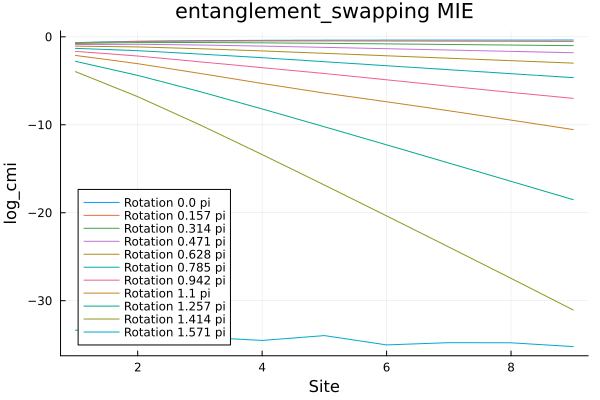

In [76]:
using Plots
reshaped_array = reshape(log.(abs.(entangle_E)), 11, 11)'
# Number of lines (rows of the array)
num_lines = size(reshaped_array, 1)

# Create a plot with multiple lines
p = plot()
for i in 1:num_lines
    angle = round(angle_list[i], digits = 3)
    plot!(1:size(reshaped_array, 2)-2, reshaped_array[i, 1 : end-2], label = "Rotation $angle pi")
end
xlabel!(p, "Site")
ylabel!(p, "log_cmi")
title!(p, "entanglement_swapping MIE")
# Display the plot
display(p)


In [78]:

using GLM

# Example data
x = [1,2,3,4,5,6,7,8,9,10,11]  # Predictor variable
X = hcat(ones(length(x)), x)
slope_list = []
slope_error_list = []
for i in 1:length(angle_list)-1
    y = reshaped_array[i, :]    # Response variable
    model = lm(X, y)

    # Get standard errors of the coefficients
    coefficients = coef(model)
    coeff_errors = stderror(model)
    
    # The standard error of the slope is the second element
    slope = coefficients[2]
    slope_error = coeff_errors[2]
    
    println("Slope: ", slope)
    println("Standard error of the slope: ", slope_error)
    push!(slope_list, slope)
    push!(slope_error_list, slope_error)
end

Slope: 0.02028607006979339
Standard error of the slope: 0.0058135839379222344
Slope: 0.0029076718124357937
Standard error of the slope: 0.00595947124060161
Slope: -0.048518635072749484
Standard error of the slope: 0.006262911482306774
Slope: -0.13452665749955064
Standard error of the slope: 0.006560667455971773
Slope: -0.2597058059451493
Standard error of the slope: 0.0067518860118524855
Slope: -0.43420596024642394
Standard error of the slope: 0.00659859195402965
Slope: -0.6828697346489483
Standard error of the slope: 0.005774661209662323
Slope: -1.0591581120955544
Standard error of the slope: 0.004566880999973421
Slope: -2.018292568641885
Standard error of the slope: 0.019566764805238702
Slope: -3.441255931564535
Standard error of the slope: 0.03218217773780898


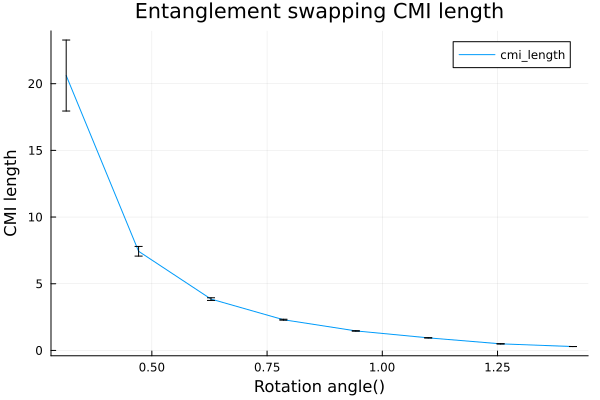

In [79]:
p = plot(angle_list[3:end-1], -1 ./ slope_list[3:end], yerr = (1 ./ slope_list[3:end]).^2 .* slope_error_list[3:end], label = "cmi_length")
xlabel!(p, "Rotation angle()")
ylabel!(p, "CMI length")
title!(p, "Entanglement swapping CMI length")

In [80]:

N = 64

# Make an array of N Index objects with alternating
# "S=1/2" and "S=1" tags on odd versus even sites
# (The first argument n->isodd(n) ... is an 
# on-the-fly function mapping integers to strings)

sites = siteinds("S=1/2", N)
entangle_E = []
pa = []
N = 64
i = 2
b = 2
P0_list = []
P1_list = []
angle_list = [0.0, 0.05*pi, 0.1*pi, 0.15*pi, 0.2*pi, 0.25*pi, 0.3*pi, 0.35*pi, 0.4*pi, 0.45*pi, 0.5*pi]

ITensors.op(::OpName"P0",::SiteType"S=1/2") =
 [1 0
  0 0]
ITensors.op(::OpName"P1",::SiteType"S=1/2") =
 [0 0
  0 1]

for angle in angle_list
    
    all_tensors = []
    os = OpSum()
    os -= 4.0*cos(angle)^2, "Sx",1,"Sz",2
    os -= 4.0*cos(angle)*sin(angle), "Sz",1,"Sz",2
    os += 4.0*sin(angle)^2, "Sz",1,"Sx",2
    os += 4.0*cos(angle)*sin(angle), "Sx",1,"Sx",2
    
    os -= 4.0*cos(angle)^2, "Sz", N-1,"Sx",N
    os -= 4.0*cos(angle)*sin(angle), "Sz", N-1,"Sz",N
    os += 4.0*sin(angle)^2, "Sx", N-1,"Sz",N
    os += 4.0*cos(angle)*sin(angle), "Sx", N-1,"Sx",N
    
    for j=1:N-2
        os -= 8.0*cos(angle)^3, "Sz",j,"Sx",j+1,"Sz",j+2
        os += 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sx",j+1, "Sz", j+2
        os -= 8.0*cos(angle)^2*sin(angle), "Sz",j,"Sz",j+1, "Sz", j+2
        os += 8.0*cos(angle)^2*sin(angle), "Sz",j,"Sx",j+1,"Sx", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sx",j,"Sz",j+1, "Sz", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sz",j+1, "Sx", j+2
        os -= 8.0*cos(angle)*sin(angle)^2, "Sx",j,"Sx",j+1,"Sx", j+2
        os -= 8.0*sin(angle)^3, "Sx",j,"Sz",j+1,"Sx", j+2
    end
    

    H = MPO(os,sites)

    nsweeps = 5
    maxdim = [10,20,40,80,200]
    cutoff = [1E-10]
    mind = [3, 3, 3, 3, 3]
    noise = [1E-5, 1E-6, 1E-7, 1E-8, 0.0]
    psi0 = randomMPS(sites,10)

    energy, psi = dmrg(H, psi0; nsweeps, maxdim, cutoff, noise)
    for i in 2:12
        # Apply the projection operator to the MPS at site i
        entangle_Ei = 0
        for a in 1:2^(i-1)
            pa_i = 1
            ind = 2
            psi_i = deepcopy(psi)
            combination = digits(a, base = 2, pad = i - 1)
            reverse!(combination)
            for com in combination
                if com == 0
                    new_psi_i = op("P0", sites[ind])*psi_i[ind]
                    noprime!(new_psi_i)
                    psi_i[ind] = new_psi_i
                    ind += 1
                else
                    new_psi_i = op("P1", sites[ind])*psi_i[ind]
                    noprime!(new_psi_i)
                    psi_i[ind] = new_psi_i
                    ind += 1 
                end
            end
            
            pa_i = inner(psi, psi_i)
            
             # Normalize the MPS
            if inner(psi, psi_i) > 1e-20
                normalize!(psi_i)
                orthogonalize!(psi_i, b)
                U,S,V = svd(psi_i[b], (linkind(psi_i, b-1), siteind(psi_i,b)))
                SvN = 0.0
                for n=1:dim(S, 1)
                    p = S[n,n]^2
                    SvN -= p * log(p+1e-32)
                end
                entangle_Ei += SvN*pa_i
            end
        end
        push!(entangle_E, entangle_Ei)
    end
end


After sweep 1 energy=-63.998977377873295  maxlinkdim=10 maxerr=1.84E-03 time=0.081
After sweep 2 energy=-63.99999986310804  maxlinkdim=7 maxerr=9.85E-11 time=0.068
After sweep 3 energy=-63.999999999999986  maxlinkdim=2 maxerr=6.60E-11 time=0.057
After sweep 4 energy=-63.99999999999978  maxlinkdim=2 maxerr=5.55E-16 time=0.064
After sweep 5 energy=-63.999999999999964  maxlinkdim=2 maxerr=5.55E-16 time=0.053
After sweep 1 energy=-63.99935608061638  maxlinkdim=10 maxerr=1.03E-03 time=0.071
After sweep 2 energy=-63.99999995167007  maxlinkdim=6 maxerr=9.98E-11 time=0.063
After sweep 3 energy=-64.00000000000004  maxlinkdim=2 maxerr=6.52E-12 time=0.066
After sweep 4 energy=-64.00000000000016  maxlinkdim=2 maxerr=6.10E-16 time=0.055
After sweep 5 energy=-63.99999999999999  maxlinkdim=2 maxerr=7.77E-16 time=0.048
After sweep 1 energy=-63.999425089812895  maxlinkdim=10 maxerr=1.41E-03 time=0.074
After sweep 2 energy=-63.99999990450738  maxlinkdim=5 maxerr=9.97E-11 time=0.067
After sweep 3 energy=

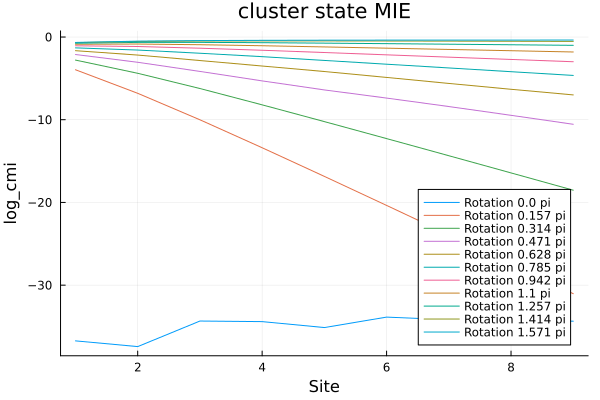

In [81]:
reshaped_array = reshape(log.(abs.(entangle_E)), 11, 11)'
# Number of lines (rows of the array)
num_lines = size(reshaped_array, 1)

# Create a plot with multiple lines
p = plot()
for i in 1:num_lines
    angle = round(angle_list[i], digits = 3)
    plot!(1:size(reshaped_array, 2)-2, reshaped_array[i, 1 : end-2], label = "Rotation $angle pi")
end
xlabel!(p, "Site")
ylabel!(p, "log_cmi")
title!(p, "cluster state MIE")
# Display the plot
display(p)

In [83]:

using GLM

# Example data
x = [1,2,3,4,5,6,7,8,9,10,11]  # Predictor variable
X = hcat(ones(length(x)), x)
slope_list = []
slope_error_list = []
for i in 1:length(angle_list)-1
    y = reshaped_array[i, :]    # Response variable
    model = lm(X, y)

    # Get standard errors of the coefficients
    coefficients = coef(model)
    coeff_errors = stderror(model)
    
    # The standard error of the slope is the second element
    slope = coefficients[2]
    slope_error = coeff_errors[2]
    
    println("Slope: ", slope)
    println("Standard error of the slope: ", slope_error)
    push!(slope_list, slope)
    push!(slope_error_list, slope_error)
end

Slope: 0.21924196242343238
Standard error of the slope: 0.08882964174782736
Slope: -3.3114809860382506
Standard error of the slope: 0.08024732604451716
Slope: -2.0182928729217475
Standard error of the slope: 0.01956682705156211
Slope: -1.0591581121184792
Standard error of the slope: 0.004566880999534252
Slope: -0.682869734648551
Standard error of the slope: 0.005774661209626468
Slope: -0.43420596024641517
Standard error of the slope: 0.0065985919540293165
Slope: -0.25970580594514886
Standard error of the slope: 0.006751886011852301
Slope: -0.13452665749955
Standard error of the slope: 0.006560667455971543
Slope: -0.048518635072749096
Standard error of the slope: 0.00626291148230689
Slope: 0.002907671812436001
Standard error of the slope: 0.005959471240601651


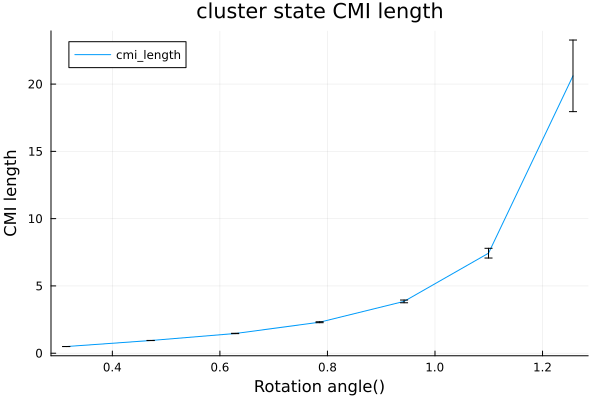

In [85]:
p = plot(angle_list[3:end-2], -1 ./ slope_list[3:end-1], yerr = (1 ./ slope_list[3:end-1]).^2 .* slope_error_list[3:end-1], label = "cmi_length")
xlabel!(p, "Rotation angle()")
ylabel!(p, "CMI length")
title!("cluster state CMI length")